In [1]:
!pip install yellowbrick
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import statsmodels.api as sm 
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from yellowbrick.regressor import ResidualsPlot
from xgboost import XGBRegressor


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
data= pd.read_excel("./Flight_Fare.xlsx")

# Exploratory Data Analysis

In [3]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
data.tail()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648
10682,Air India,9/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,10:55,19:15,8h 20m,2 stops,No info,11753


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [6]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [7]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [8]:
data.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [9]:
data['Additional_Info'].value_counts()

Additional_Info
No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

In [10]:
data['Airline'].value_counts()

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64

In [11]:
data['Source'].value_counts()

Source
Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64

In [12]:
data['Destination'].value_counts()

Destination
Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

In [13]:
data['Total_Stops'].value_counts()

Total_Stops
1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [14]:
data[data['Airline'] == 'Jet Airways Business']['Additional_Info'].value_counts()

Additional_Info
No info           3
Business class    3
Name: count, dtype: int64

In [15]:
data.loc[data['Airline'] == "Multiple carriers Premium economy", 'Additional_Info'].value_counts()

Additional_Info
No info    13
Name: count, dtype: int64

In [16]:
data.loc[data['Airline'] == 'Vistara Premium economy', 'Additional_Info'].value_counts()

Additional_Info
No info    3
Name: count, dtype: int64

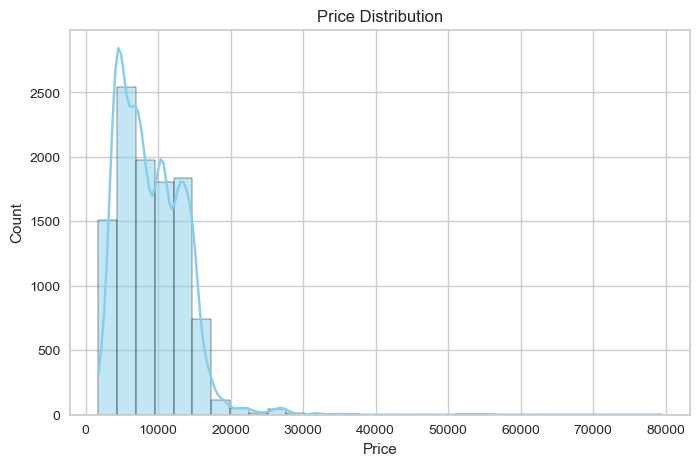

In [17]:
# Price Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['Price'], bins=30, kde=True, color='skyblue')
plt.title('Price Distribution')
plt.show()

In [18]:
contineous_features = ["Duration"]
discrete_features = []
ordinal_features = ["Dep_Time", "Arrival_Time", "Total_Stops", "Date_of_Journey"]
nominal_features = ["Airline", "Source", "Destination", "Route", "Additional_Info"]

# Preprocessing

## Remove Redundant Columns

In [19]:
# Route not needed since it's captured in Total_Stops and Arrival and Departure features
# Remove Arrival_Time as this is capture from Departure Time and Duration
data.drop(["Route", "Arrival_Time"], axis=1, inplace=True)
ordinal_features.remove("Arrival_Time")
nominal_features.remove("Route")

## Data with duplicate values because of casing

In [20]:
categorical_columns = ["Airline", "Source", "Destination", "Total_Stops", "Additional_Info"]
for col in categorical_columns:
    data[col] = data[col].str.lower().str.strip()

## Change Duplicate Records to the same

In [21]:
data.loc[data['Airline'] == 'jet airways business', 'Additional_Info'] = 'business class'
data.loc[data['Airline'] == 'jet airways business', 'Airline'] = 'jet airways'
data.loc[data['Airline'] == "multiple carriers premium economy", 'Additional_Info'] = 'premium economy class'
data.loc[data['Airline'] == "multiple carriers premium economy", 'Airline'] = 'multiple carriers'
data.loc[data['Airline'] == 'vistara premium economy', 'Additional_Info'] = 'premium economy class'
data.loc[data['Airline'] == 'vistara premium economy', 'Airline'] = 'vistara'
data.loc[data['Destination'] == 'new delhi', 'Destination'] = 'delhi'

## Impute Missing Values

In [22]:
data['Total_Stops'] = data['Total_Stops'].fillna(data['Total_Stops'].mode()[0])

## Encode Ordinal Data

In [23]:
encoder = OrdinalEncoder(categories=[["non-stop", "1 stop", "2 stops", "3 stops", "4 stops"]])
data['Total_Stops'] = encoder.fit_transform(data[['Total_Stops']])
data['Total_Stops'] = data['Total_Stops'].astype(int)

## Date Conversion

In [24]:
def extract_duration(duration_str):
    """Extracts hours and minutes from a duration string.

    Args:
        duration_str: The duration string in the format "HHh MMm" or "HHh" or "MMm".

    Returns:
        A tuple containing the number of hours and minutes.
    """
    hours = 0
    minutes = 0
    if 'h' in duration_str:
        hours_str, rest = duration_str.split('h')
        hours = int(hours_str)
    if 'm' in duration_str:
        if 'h' in duration_str:
            minutes_str = rest.strip('m') 
        else:
            minutes_str = duration_str.strip('m')
        minutes = int(minutes_str)
    return hours, minutes

In [25]:
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], format='%d/%m/%Y')
# Extract day, month, year
data['Journey_day'] = data['Date_of_Journey'].dt.day
data['Journey_month'] = data['Date_of_Journey'].dt.month
data['Journey_year'] = data['Date_of_Journey'].dt.year

ordinal_features.extend(["Journey_day", "Journey_month", "Journey_year"])

# Extract day of the week
data['Journey_day_of_week'] = data['Date_of_Journey'].dt.day_name() 
nominal_features.extend(['Journey_day_of_week'])

data['Dep_Time'] = pd.to_datetime(data['Dep_Time'], format='%H:%M')

# Extract hour and minute from 'Dep_Time'
data['Dep_hour'] = pd.to_datetime(data['Dep_Time']).dt.hour
data['Dep_min'] = pd.to_datetime(data['Dep_Time']).dt.minute
ordinal_features.extend(['Dep_hour', 'Dep_min'])

# Extract hours and minutes from 'Duration'
data['Duration_hours'], data['Duration_mins'] = zip(*data['Duration'].apply(extract_duration))

# Convert 'Duration_hours' and 'Duration_mins' to numeric
data['Duration_hours'] = data['Duration_hours'].astype(int)
data['Duration_mins'] = data['Duration_mins'].astype(int)
contineous_features.extend(['Duration_hours', 'Duration_mins'])
    
# Calculate total duration in minutes
data['Duration_total_mins'] = data['Duration_hours'] * 60 + data['Duration_mins'] 
contineous_features.extend(['Duration_total_mins'])

# Drop original columns
data.drop(['Date_of_Journey', 'Dep_Time', 'Duration', 'Duration_hours', 'Duration_mins'], axis=1, inplace=True) 
ordinal_features.remove('Date_of_Journey')
ordinal_features.remove("Dep_Time")
contineous_features.remove('Duration')
contineous_features.remove("Duration_hours")
contineous_features.remove('Duration_mins')

### Check the distribution of years

In [26]:
data['Journey_year'].value_counts()

Journey_year
2019    10683
Name: count, dtype: int64

### Check the distribution of Duration of Total Minutes

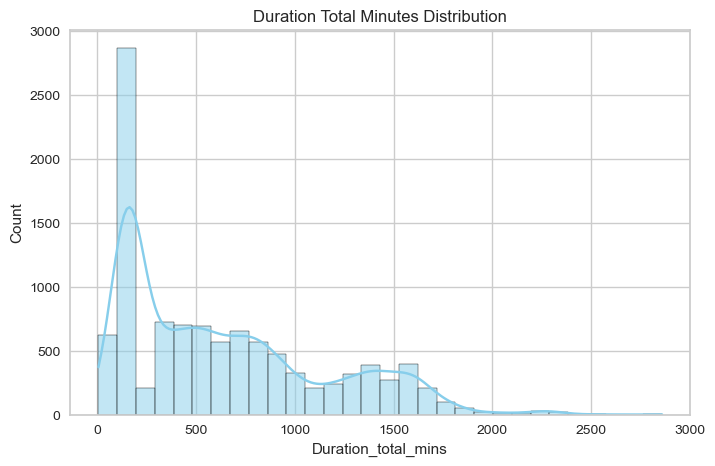

In [27]:
# Duration Total Minutes Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['Duration_total_mins'], bins=30, kde=True, color='skyblue')
plt.title('Duration Total Minutes Distribution')
plt.show()

## Encoding

In [28]:
data = pd.get_dummies(data, columns=nominal_features, drop_first=True)

In [29]:
bool_columns = data.select_dtypes(include=["bool"]).columns
data[bool_columns] = data[bool_columns].astype("int")

## Check for Homoscedasticity

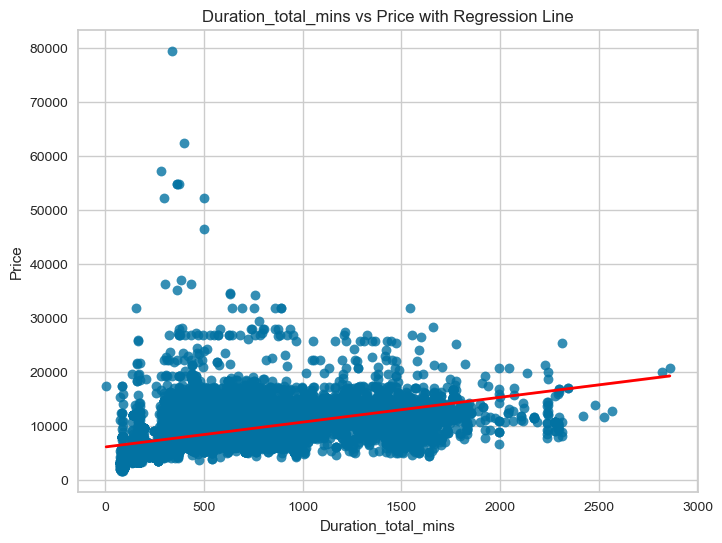

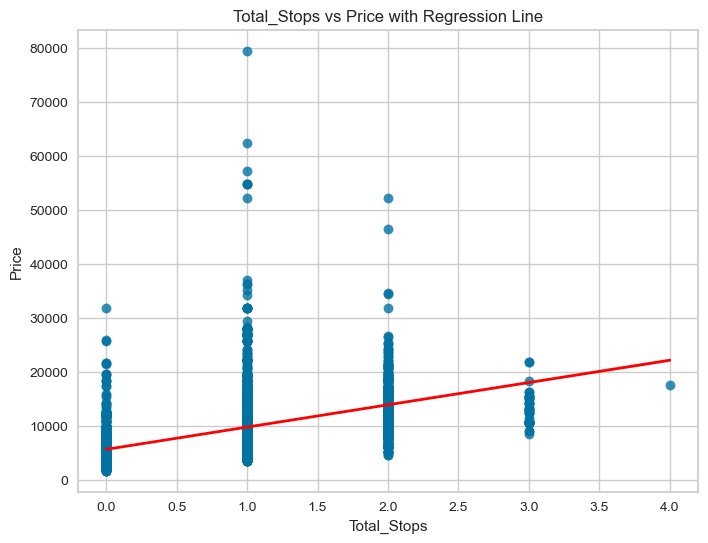

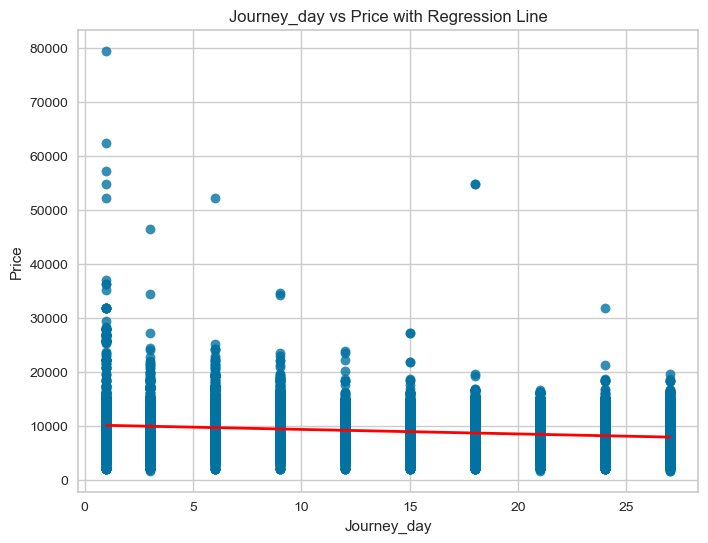

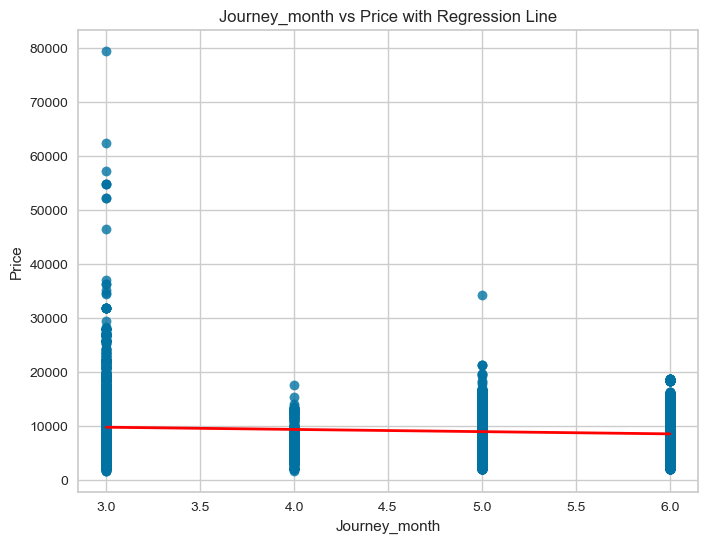

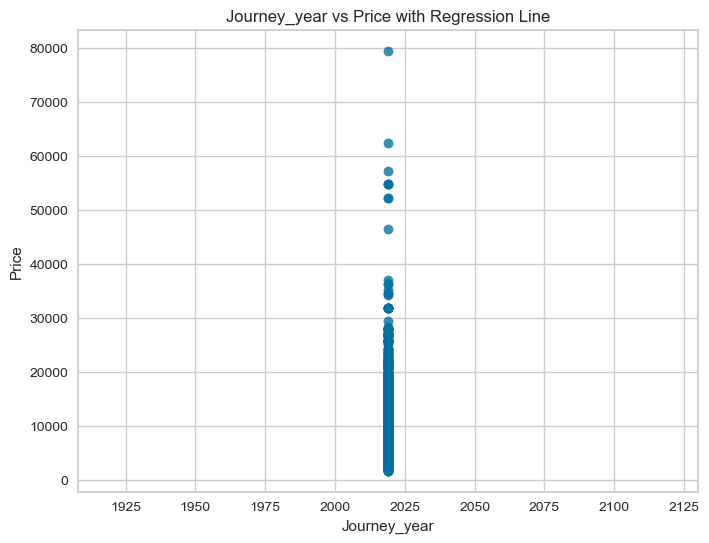

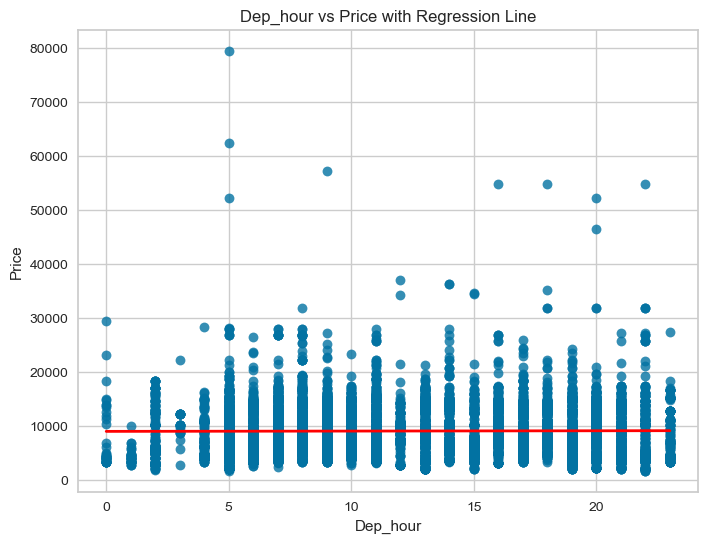

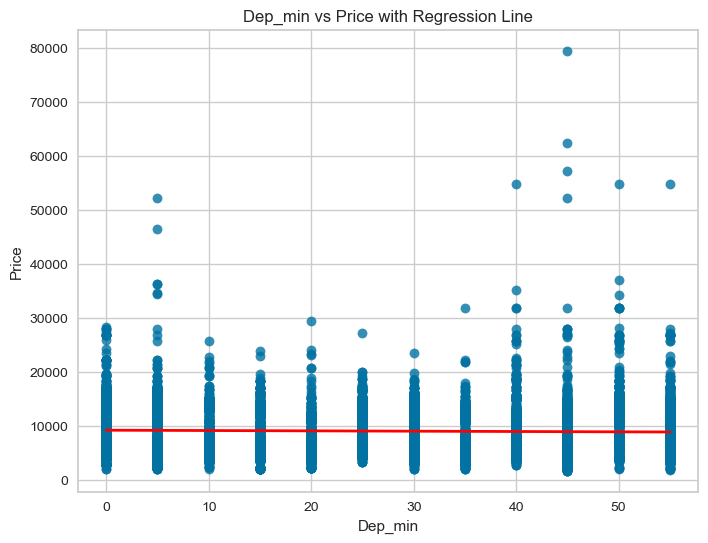

In [30]:
numeric_features = contineous_features + discrete_features + ordinal_features
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feature, y='Price', data=data, scatter_kws={'s': 50}, line_kws={'color': 'red', 'lw': 2})
    plt.title(f'{feature} vs Price with Regression Line')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

## Normalization and standardization

In [31]:
scaler = RobustScaler()
data['Duration_total_mins'] = scaler.fit_transform(data[['Duration_total_mins']])

In [32]:
selected_features = [feature for feature in ordinal_features if feature != "total_stops"]
ordinalEncoder = OrdinalEncoder()
standardScalar = StandardScaler()
data[selected_features] = ordinalEncoder.fit_transform(data[selected_features])
data[selected_features] = standardScalar.fit_transform(data[selected_features])

In [33]:
data[['Total_Stops', 'Journey_day', 'Journey_month', 'Journey_year', 'Dep_hour', 'Dep_min', 'Duration_total_mins']] = data[['Total_Stops', 'Journey_day', 'Journey_month', 'Journey_year', 'Dep_hour', 'Dep_min', 'Duration_total_mins']].astype(int)

## Feature Engineering

In [34]:
X = data.drop("Price", axis=1)
Y  = data["Price"]
x = sm.add_constant(X)
est = sm.OLS(Y, x).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     687.3
Date:                Wed, 08 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:41:07   Log-Likelihood:                -99188.
No. Observations:               10683   AIC:                         1.984e+05
Df Residuals:                   10649   BIC:                         1.987e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [35]:
p_values = est.pvalues
# Set a threshold for statistical significance (commonly 0.05)
significant_features = p_values[p_values < 0.05]
# Print the number of statistically significant features
print(f"Number of statistically significant features: {len(significant_features)}")

Number of statistically significant features: 32


In [36]:
from sklearn.feature_selection import RFE

X = data.drop(columns=['Price']) 
y = data['Price'] 

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = RandomForestRegressor()

# Initialize RFE with the model and the desired number of features
rfe = RFE(estimator=model, n_features_to_select=32)

# Fit the RFE model on the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

# Print the selected features
X_train = X_train[selected_features]
X_test= X_test[selected_features]
contineous_features = [feature for feature in contineous_features if feature in selected_features]
discrete_features = [feature for feature in discrete_features if feature in selected_features]
ordinal_features = [feature for feature in ordinal_features if feature in selected_features]
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Model Evaluation

## Random Forest Regressor

### Training

In [ ]:
# Define the parameter distribution for Random Forest Regressor
param_dist = {
    'n_estimators': randint(50, 500),  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # Number of features to consider for splitting
    'max_depth': randint(10, 100),  # Maximum depth of the tree
    'min_samples_split': randint(2, 15),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 15),  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize Random Forest Regressor (without specifying hyperparameters)
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV with the parameter distribution
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=150,  # Number of different hyperparameter combinations to sample
    cv=kfold,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    verbose=1,
    random_state=42,  # Fix random seed for reproducibility
    n_jobs=-1  # Use all cores for faster computation
)

# Train the model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model from the random search
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Param: ", best_params)
print("Best Score: ", best_score)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


### Prediction

In [ ]:
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Model Performance
print("\nRandom Forest Model Performance (RandomizedSearchCV):")
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)
print(f"R-Squared Value: {r2:.2f}")

### Visuals 

In [ ]:
visualizer = ResidualsPlot(best_model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the plot

## Lasso

In [ ]:
data['Price'] = np.log1p(data['Price'])

In [ ]:
transformers = [
    ('poly_continuous', PolynomialFeatures(include_bias=False), contineous_features),
    ('poly_ordinal', PolynomialFeatures(include_bias=False), ordinal_features)
]

preprocessor = ColumnTransformer(transformers, remainder="passthrough")

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),  # Scale features to avoid issues with Lasso
    ('lasso', Lasso())
])

param_grid = {
    'preprocessor__poly_continuous__degree': [1, 2, 3, 4],
    'preprocessor__poly_ordinal__degree': [1, 2, 3, 4],
    'lasso__alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
    'lasso__max_iter': [1000, 5000, 10000,20000],  # Maximum number of iterations
    'lasso__tol': [1e-4, 1e-3, 1e-5]        # Tolerance for stopping criteria
}

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=500,
    cv=kfold,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use MSE as the metric
    verbose=1,
    random_state=42,  # For reproducibility
)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Param: ", best_params)
print("Best R2: ", best_score) 

## Predict

In [ ]:
# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Model Performance
print("\nLinear Regression Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared Value: {r2:.2f}")

### Visualization

In [ ]:
visualizer = ResidualsPlot(best_model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()        

## XgBoost

### Training

In [89]:
xgb = XGBRegressor()
param_grid = {
    'max_depth': range(4, 10, 2),
    'min_child_weight': range(3, 6, 2),
    'gamma': [i / 10.0 for i in range(2, 5)],
    'subsample': [i / 10.0 for i in range(7, 10)],
    'colsample_bytree': [i / 10.0 for i in range(4, 10)],
    'reg_alpha': [0, 0.001, 0.01]
}
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid,
                                   n_iter=150, scoring='neg_mean_squared_error',
                                   cv=kfold, verbose=1, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_score = random_search.best_score_
print("Best param: ", best_params)
print("Best Score: ", best_score)


Fitting 10 folds for each of 150 candidates, totalling 1500 fits


/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best param:  {'subsample': 0.9, 'reg_alpha': 0.001, 'min_child_weight': 3, 'max_depth': 6, 'gamma': 0.4, 'colsample_bytree': 0.7}
Best Score:  -3608343.439015776


### Prediction

In [90]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Model Performance
print("\nLinear Regression Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared Value: {r2:.2f}")


Linear Regression Performance:
Mean Squared Error: 3509598.38
Root Mean Squared Error (RMSE): 1873.39
R-Squared Value: 0.83


### Visualization

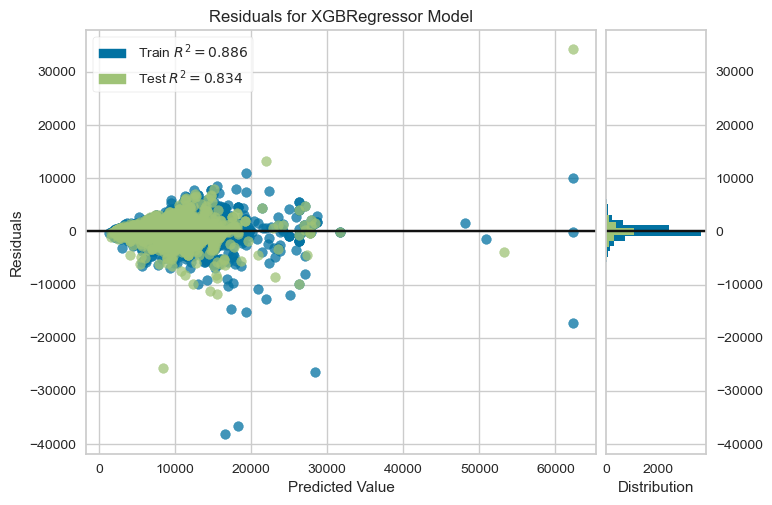

<Axes: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [91]:
visualizer = ResidualsPlot(best_model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the plot